## Expand the Layer Class

It's great that `Layer` manage the `parameters` easily!<br>
But still we have to manage the `layers`!

- 1 layer Neural network : 1 layer
- 10 layer Neural network : 10 layer

So we want to manage this layers more easily!

In [2]:
from dezero.core import Parameter
from dezero.layers import Layer

class Layer:
    def __init__(self):
        self._params = set()
        
    def __setattr__(self, name, value):
        if isinstance(value, (Parameter, Layer)):
            self._params.add(name)
        super().__setattr__(name, value)
        
    def params(self):
        for name in self._params:
            obj = self.__dict__[name]
            
            if isinstance(obj, Layer):
                yield from obj.params()
            else:
                yield obj


`yield from` used to make generator inside generator

In [5]:
def params():
    x = [1, 2, 3, [4, 5, 6], 7, 8]
    for i in x:
        if isinstance(i, list):
            yield i
        else:
            yield i
        
for i in params():
    print(i)

1
2
3
[4, 5, 6]
7
8


In [6]:
def params():
    x = [1, 2, 3, [4, 5, 6], 7, 8]
    for i in x:
        if isinstance(i, list):
            yield from i
        else:
            yield i
        
for i in params():
    print(i)

1
2
3
4
5
6
7
8


**how about `recursive` :)?**

In [33]:
def params(iter):
    if iter == 0:
        return 0
    
    print(f'params start iter : {iter}')
    x = [1, 2, 3, params(iter - 1), 7, 8]
    for i in x:
        if i.__class__.__name__ == 'generator':
            print(f'sub params start iter : {iter - 1}')
            yield from i
            print(f'sub params end iter : {iter - 1}')
        else:
            yield i
    print(f'params end iter : {iter}')
        
for i in params(3):
    print(i)

params start iter : 3
1
2
3
sub params start iter : 2
params start iter : 2
1
2
3
sub params start iter : 1
params start iter : 1
1
2
3
sub params start iter : 0
sub params end iter : 0
7
8
params end iter : 1
sub params end iter : 1
7
8
params end iter : 2
sub params end iter : 2
7
8
params end iter : 3


We can improve this to support **`auto in_size setting`**

## Implement `Neural Network` with `Linear` class

In [1]:
from dezero import Layer
import dezero.functions as F
import dezero.layers as L

In [4]:
model = Layer()
model.l1 = L.Linear(5)
model.l2 = L.Linear(3)

def neural_network(model, x):
    y = model.l1(x)
    y = F.sigmoid(y)
    y = model.l2(y)
    return y

for p in model.params():
    print(p)
    
print(model.__dict__)
    
model.cleargrads()

Variable(None)
Variable([0. 0. 0. 0. 0.])
Variable(None)
Variable([0. 0. 0.])
{'_params': {'l1', 'l2'}, 'l1': <dezero.layers.Linear object at 0x000001F754C5A8C8>, 'l2': <dezero.layers.Linear object at 0x000001F754CB3308>}


## `Layer` class inside `Layer` :D!

In [5]:
class TwoLayerNet(Layer):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        
    def forward(self, x):
        y = self.l1(x)
        y = F.sigmoid(y)
        y = self.l2(y)
        return y

## `Model` class

In [7]:
from dezero import Layer
from dezero import utils

class Model(Layer):
    def plot(self, *inputs, to_file='model.png'):
        y = self.forward(*inputs)
        return utils.plot_dot_graph(y, verbose=True, to_file=to_file)

In [2]:
import numpy as np

from dezero import Variable
from dezero import Model

import dezero.layers as L
import dezero.functions as F

class TwoLayerNet(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.l1 = L.Linear(hidden_size)
        self.l2 = L.Linear(out_size)
        
    def forward(self, x):
        y = self.l1(x)
        y = F.sigmoid(y)
        y = self.l2(y)
        return y

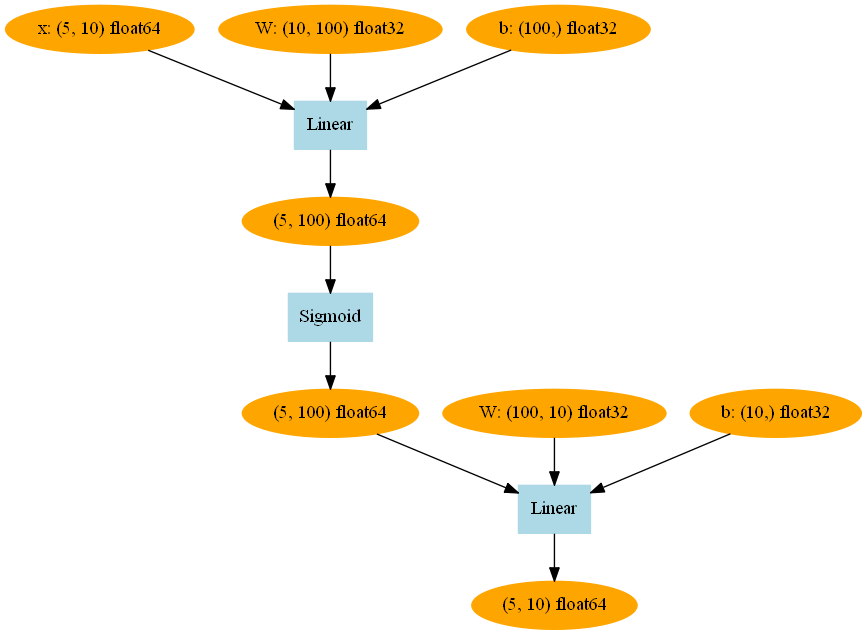

In [3]:
x = Variable(np.random.randn(5, 10), name='x')
model = TwoLayerNet(100, 10)
model.plot(x)

## Implement `2 layer neural network` with `TwoLayerNet` class

### 1. dataset

In [4]:
np.random.seed(0)
x = np.random.rand(100, 1)
y = np.sin(2 * np.pi * x) + np.random.rand(100, 1)

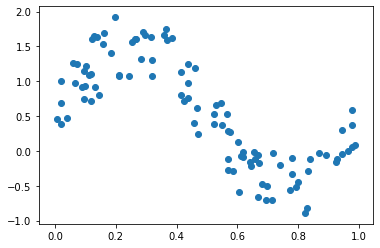

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x, y);

### 2. Model

In [6]:
hidden_size = 10

model = TwoLayerNet(hidden_size, 1)

### 3. Train

You can see the `Parameter` administration is held by `Layer`!

In [7]:
lr = 0.2
iters = 10000

for i in range(iters):
    y_pred = model(x)
    loss = F.mean_squared_error(y, y_pred)
    
    model.cleargrads()
    loss.backward()
    
    for p in model.params():
        p.data -= lr * p.grad.data
            
    if i % 1000 == 0:
        print(loss)

Variable(0.8165178492839196)
Variable(0.24990280802148895)
Variable(0.24609876581126014)
Variable(0.23721590814318072)
Variable(0.20793216413350174)
Variable(0.12311905720649353)
Variable(0.07888166506355153)
Variable(0.07655073683421634)
Variable(0.07637803086238225)
Variable(0.07618764131185568)


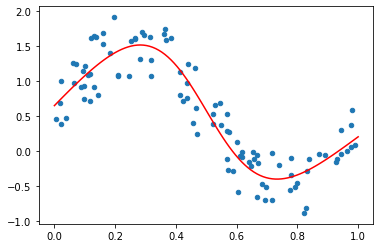

In [8]:
x_test = np.linspace(0, 1, 100).reshape(100, 1)
y_test = model(x_test)
plt.scatter(x, y, s=20)
plt.plot(x_test.data, y_test.data, color='red');

### Now we are free from managing `parameters` XD!
### We can manage everything in one `Layer` Class :)

## Implement `Multi Layer Perceptron (MLP)` with `Model` class

In [9]:
class MLP(Model):
    def __init__(self, fc_output_sizes, activation=F.sigmoid):
        super().__init__()
        self.activation = activation
        self.layers = []
        
        for i, out_size in enumerate(fc_output_sizes):
            layer = L.Linear(out_size)
            setattr(self, 'l' + str(i), layer)
            self.layers.append(layer)
            
    def forward(self, x):
        for l in self.layers[:-1]:
            x = self.activation(l(x))
        return self.layers[-1](x)

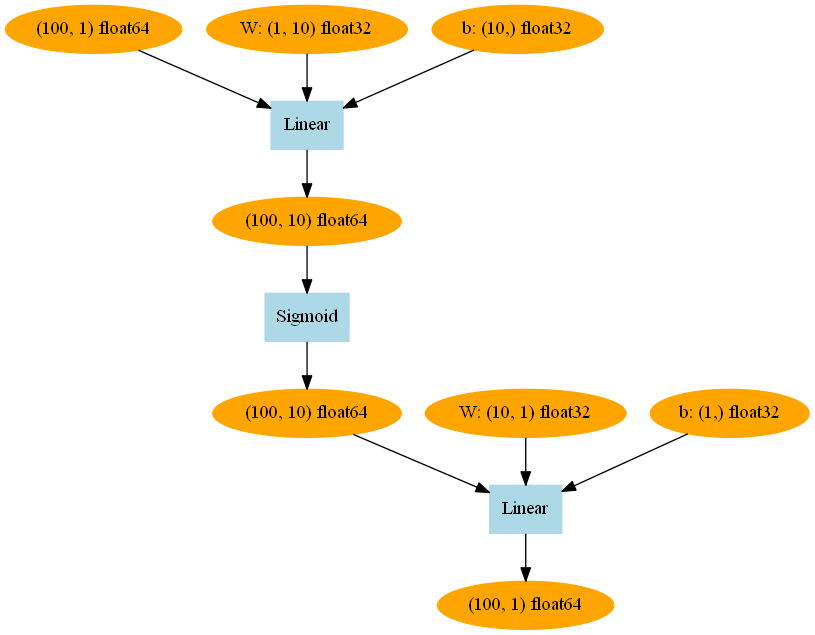

In [11]:
model = MLP((10, 1))
model.plot(x)

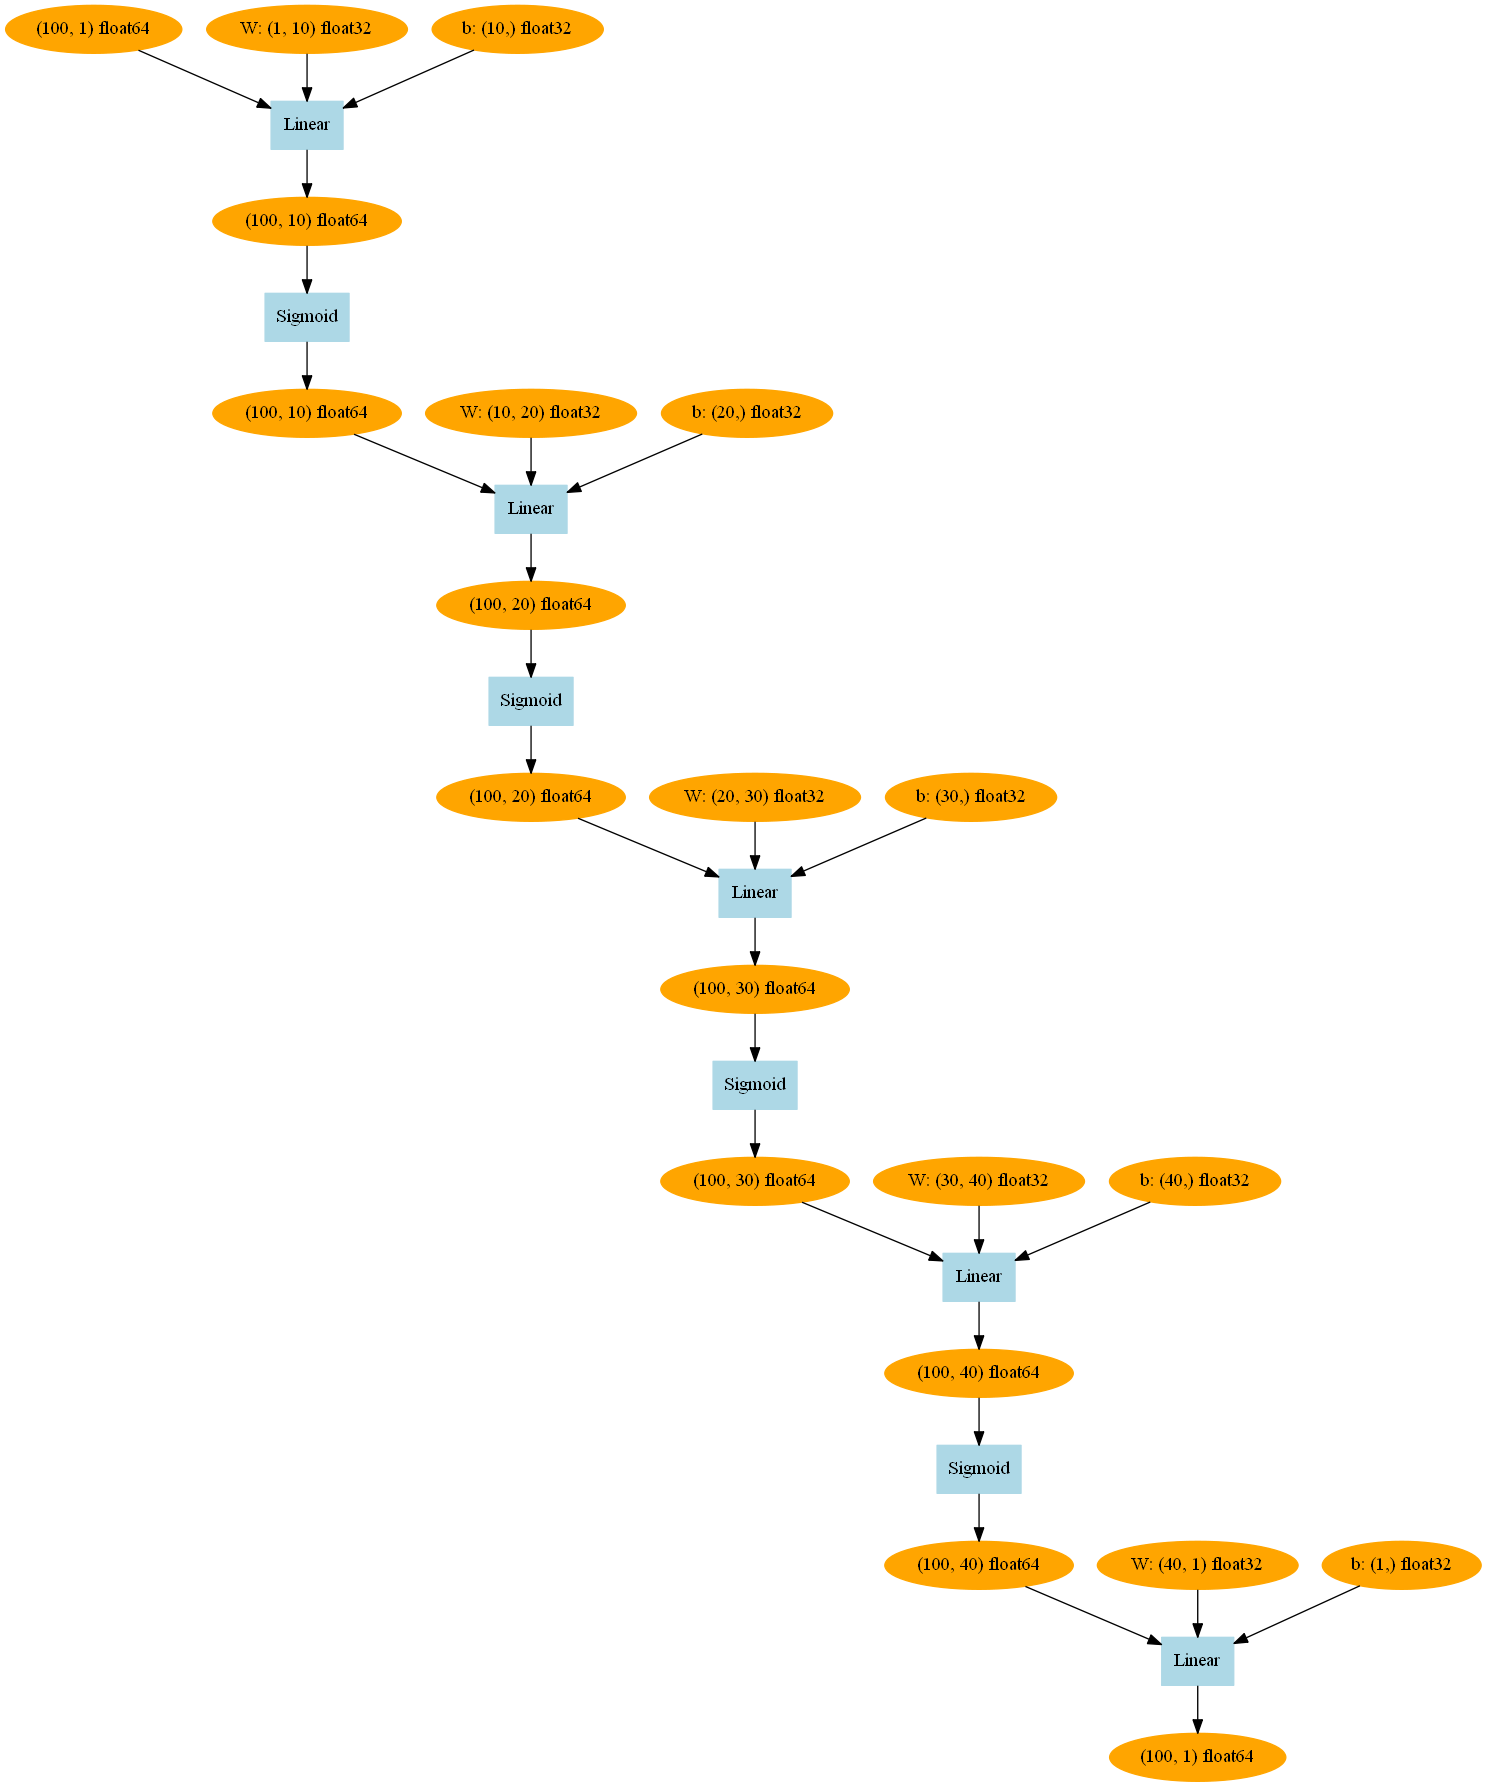

In [12]:
model = MLP((10, 20, 30, 40, 1))
model.plot(x)